In [1]:
%cd ../..

c:\Users\yanic\dev\ethz\cil\CIL2023


Can be used to visualize:
- the influence of any pixel t on all other pixels

In [2]:
import matplotlib.pyplot as plt
from ipywidgets import interact

import torchvision
from torchvision.io import ImageReadMode
import numpy as np
import os

from scipy import stats

In [3]:
# folders should contain mean/ and std/ subfolders
angle_folder = "out/madw_angle/run_test500"
distance_folder = "out/madw_dist/run_test500_last"
width_folder = "out/madw_width/run_test500_last"

# folder should contain images/ and groundtruth/ subfolders
dataset_folder = "data/test500"

#### This must be the same as in ADW-Transform!

In [4]:
PADDING = 25
SMOOTH_ANGLE = 2.0 # None to disable
SMOOTH_WIDTH = 1.0 # None to disable
SMOOTH_MASK_ITERATIONS = 3

# the image size that the model will be working on (matters for distance prediction!)
TARGET_SIZE = (224,224) 
# leave at (400,400) if doing cropping
# use (224,224) if rescaling

NORM_ANGLE_MIN, NORM_ANGLE_DELTA = -3.15, 6.3
NORM_DISTANCE_MIN, NORM_DISTANCE_DELTA = 0, np.sqrt(2*(TARGET_SIZE[0] + 2*PADDING)**2) + 1
NORM_WIDTH_MIN, NORM_WIDTH_DELTA = 0, TARGET_SIZE[0] / 4 # this might cause some overflows if chosen too small
RESIZE_FACTOR = 0.25

In [5]:
def norm_to_true(angle_mean, angle_std, distance_mean, distance_std, width_mean, width_std, 
                 angle_min, angle_delta, distance_min, distance_delta, width_min, width_delta):
    angle_mean = angle_mean * angle_delta + angle_min
    angle_std = angle_std * angle_delta

    distance_mean = distance_mean * distance_delta + distance_min
    distance_std = distance_std * distance_delta

    width_mean = width_mean * width_delta + width_min
    width_std = width_std * width_delta    

    return angle_mean, angle_std, distance_mean, distance_std, width_mean, width_std

In [6]:
def load_sample(name):
    angle_mean = (torchvision.io.read_image(os.path.join(angle_folder, 'mean', name), mode=ImageReadMode.GRAY).squeeze()/255.0).numpy()
    angle_std = (torchvision.io.read_image(os.path.join(angle_folder, 'std', name), mode=ImageReadMode.GRAY).squeeze()/255.0).numpy()
    distance_mean = (torchvision.io.read_image(os.path.join(distance_folder, 'mean', name), mode=ImageReadMode.GRAY).squeeze()/255.0).numpy()
    distance_std = (torchvision.io.read_image(os.path.join(distance_folder, 'std', name), mode=ImageReadMode.GRAY).squeeze()/255.0).numpy()
    width_mean = (torchvision.io.read_image(os.path.join(width_folder, 'mean', name), mode=ImageReadMode.GRAY).squeeze()/255.0).numpy()
    width_std = (torchvision.io.read_image(os.path.join(width_folder, 'std', name), mode=ImageReadMode.GRAY).squeeze()/255.0).numpy()

    return norm_to_true(angle_mean, angle_std, distance_mean, distance_std, width_mean, width_std, 
                        NORM_ANGLE_MIN, NORM_ANGLE_DELTA, NORM_DISTANCE_MIN, NORM_DISTANCE_DELTA, NORM_WIDTH_MIN, NORM_WIDTH_DELTA)

In [7]:
def nearest_neighbor_interpolation_2D(arr, target_size):
    current_size = arr.shape
    row_ratio, col_ratio = np.array(target_size)/np.array(current_size)

    row_idx = (np.ceil(range(1, 1 + int(current_size[0]*row_ratio))/row_ratio) - 1).astype(int)
    col_idx = (np.ceil(range(1, 1 + int(current_size[1]*col_ratio))/col_ratio) - 1).astype(int)

    return arr[:,row_idx][col_idx,:]

In [8]:
def nearest_neighbor_interpolation_2D_RGB(arr, target_size):
    return np.stack([nearest_neighbor_interpolation_2D(arr[0,:,:], target_size), nearest_neighbor_interpolation_2D(arr[1,:,:], target_size), nearest_neighbor_interpolation_2D(arr[2,:,:], target_size)])

In [110]:
name = 'los_angeles_satimage_89.png'
angle_mean, angle_std, dist_mean, dist_std, width_mean, width_std = load_sample(name)

satellite = (torchvision.io.read_image(os.path.join(dataset_folder, 'images', name), mode=ImageReadMode.RGB).squeeze()).numpy()
groundtruth = (torchvision.io.read_image(os.path.join(dataset_folder, 'groundtruth', name), mode=ImageReadMode.GRAY).squeeze() / 255.0).numpy()

In [111]:
original_size = angle_mean.shape[-1]
# subsample
size = round(RESIZE_FACTOR * original_size)

res_total_weight = np.zeros((size,size))
res_width_mean = np.zeros((size,size))
res_width_std = np.zeros((size,size))

angle_mean = nearest_neighbor_interpolation_2D(angle_mean, (size,size)) # invariant to scaling
angle_std = nearest_neighbor_interpolation_2D(angle_std, (size,size))
dist_mean = nearest_neighbor_interpolation_2D(dist_mean, (size,size)) * RESIZE_FACTOR # k * X ~ N(k * m, (k*s)^2)
dist_std = nearest_neighbor_interpolation_2D(dist_std, (size,size)) * RESIZE_FACTOR
width_mean = nearest_neighbor_interpolation_2D(width_mean, (size,size)) # keep original scale
width_std = nearest_neighbor_interpolation_2D(width_std, (size,size))

satellite = nearest_neighbor_interpolation_2D_RGB(satellite, (size, size))
groundtruth = nearest_neighbor_interpolation_2D(groundtruth, (size, size))

indices_ext = np.array([range(-size+1, size)]).T @ np.ones((1,2*size-1))
dists = np.sqrt(np.sum(np.stack([indices_ext**2, indices_ext.T**2], axis=-1), axis=-1))

indices_2d = np.stack([indices_ext, indices_ext.T], axis=-1)
angles = np.arctan2(indices_2d[:,:,0], indices_2d[:,:,1])

res_total_weight = np.zeros((size,size))
res_width_mean = np.zeros((size,size))
res_width_var = np.ones((size,size))

joint_norm_std = 1 / (2 * np.pi * angle_std * dist_std)

In [112]:
#ty, tx = 20,84
ty, tx = 20,75

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


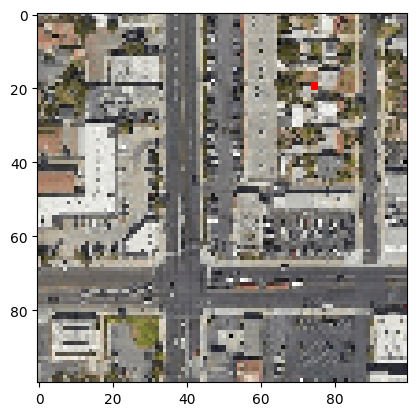

In [113]:
tmp = np.copy(satellite.transpose(1,2,0)) / 255.0
width = 1
tmp[ty-width:ty+width,tx-width:tx+width,:] = [254.0,0,0]
plt.imshow(tmp)


In [114]:
local_angle_mean = angle_mean[ty,tx]
local_angle_std = angle_std[ty,tx]
local_dist_mean = dist_mean[ty,tx]
local_dist_std = dist_std[ty,tx]
local_width_mean = width_mean[ty,tx]
local_width_std = width_std[ty,tx]
local_width_var = local_width_std**2

local_dists = dists[size-1-ty:size-1-ty+size,size-1-tx:size-1-tx+size]
local_angles = angles[size-1-ty:size-1-ty+size,size-1-tx:size-1-tx+size]
closest_local_angles = local_angles + np.sign(local_angle_mean - local_angles) * (np.abs(local_angle_mean - local_angles) > np.pi) * 2 * np.pi

influence = joint_norm_std[ty,tx] * np.exp(-0.5 * (((closest_local_angles - local_angle_mean) / local_angle_std)**2 + ((local_dists - local_dist_mean) / local_dist_std)**2))

In [115]:
norm = stats.norm(local_width_mean, local_width_std)
local_dists = dists[size-1-ty:size-1-ty+size,size-1-tx:size-1-tx+size]

prop_that_road = 1.0 - norm.cdf(local_dists)

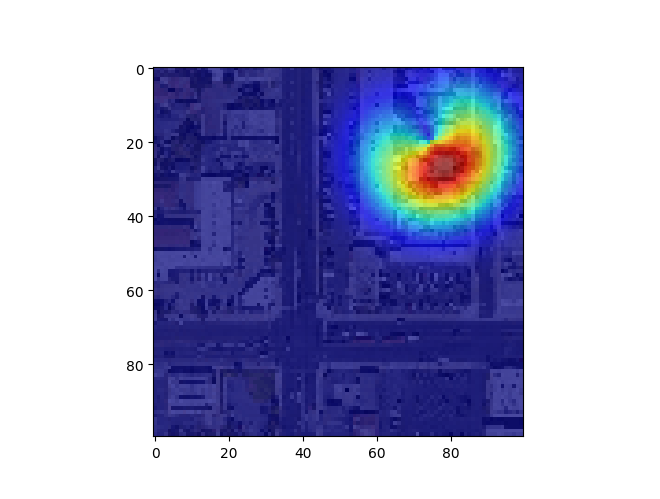

In [116]:
fig = plt.figure(frameon=False)
plt.imshow(satellite.transpose(1,2,0))
plt.imshow(influence, cmap='jet', alpha=0.7)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
plt.show()

In [120]:
print(dist_std.max())

9.9028015


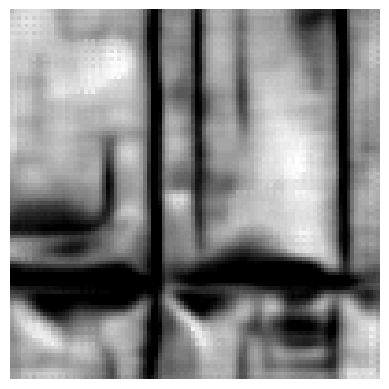

In [119]:
fig = plt.figure(frameon=False)
plt.imshow(angle_std, cmap='gray')
plt.axis('off')
plt.show()
fig.savefig('out.png', bbox_inches='tight', pad_inches=0)